<E> = -1148.975146043063


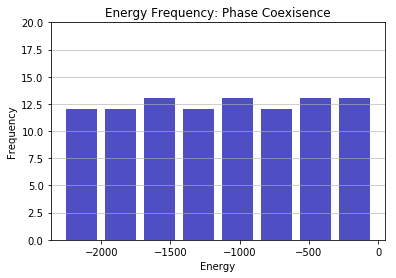

In [49]:
# Test for first order phase transition for SU(3) XY-magnet modeld

# Imports

from numpy import zeros, sqrt, arange, array, savetxt, vstack, ceil
from math import exp, pi, cos, sin
from random import random, randint, uniform
from multiprocessing import Pool
from matplotlib.pyplot import hist, grid, xlabel, ylabel, title, ylim, show

# Parameters

size_global = 8  # Linear lattice size
E_measurements = 100      # Number of independent measurements
y_tilde = 0
kappa = 1

if size_global == 8:
    tau_global = 7000
    tau_after = 800
if size_global == 16:  # Equilibration times
    tau_global = 10240
    tau_after = 1000
elif size_global == 24:
    tau_global = 14000
    tau_after = 1200
elif size_global == 32:
    tau_global = 21000
    tau_after = 4000
elif size_global == 40:
    tau_global = 31000
    tau_after = 7000
elif size_global == 64:
    tau_global = 55000
    tau_after = 10000

# Function block
    
def deltaE(config1, config2, L1, L2, s1, s2, i, j, h):
    global size_global
    size = size_global
    bound = size - 1
    dE = 0
    nhbr = i - 1
    if nhbr > -1:
        dE += cos(L1[nhbr, j] - config1) - cos(L1[nhbr, j] - s1)  + cos(L2[nhbr, j] - config2) 
        - cos(L2[nhbr, j] - s2) + cos((L1[nhbr, j] - config1) - (L2[nhbr, j] - config2))
        - cos((L1[nhbr, j] - s1) - (L2[nhbr, j] - s2))
    else:
        dE += cos(L1[bound, j] - config1) - cos(L1[bound, j] - s1)  + cos(L2[bound, j] - config2) 
        - cos(L2[bound, j] - s2) + cos((L1[bound, j] - config1) - (L2[bound, j] - config2))
        - cos((L1[bound, j] - s1) - (L2[bound, j] - s2))
    nhbr = i + 1
    if nhbr < size:
        dE += cos(L1[nhbr, j] - config1) - cos(L1[nhbr, j] - s1)  + cos(L2[nhbr, j] - config2) 
        - cos(L2[nhbr, j] - s2) + cos((L1[nhbr, j] - config1) - (L2[nhbr, j] - config2))
        - cos((L1[nhbr, j] - s1) - (L2[nhbr, j] - s2))
    else:
        dE += cos(L1[0, j] - config1) - cos(L1[0, j] - s1)  + cos(L2[0, j] - config2) 
        - cos(L2[0, j] - s2) + cos((L1[0, j] - config1) - (L2[0, j] - config2))
        - cos((L1[0, j] - s1) - (L2[0, j] - s2))
    nhbr = j - 1
    if nhbr > -1:
        dE += cos(L1[i, nhbr] - config1) - cos(L1[i, nhbr] - s1)  + cos(L2[i, nhbr] - config2) 
        - cos(L2[i, nhbr] - s2) + cos((L1[i, nhbr] - config1) - (L2[i, nhbr] - config2))
        - cos((L1[i, nhbr] - s1) - (L2[i, nhbr] - s2))
    else:
        dE += cos(L1[i, bound] - config1) - cos(L1[i, bound] - s1)  + cos(L2[i, bound] - config2) 
        - cos(L2[i, bound] - s2) + cos((L1[i, bound] - config1) - (L2[i, bound] - config2))
        - cos((L1[i, bound] - s1) - (L2[i, bound] - s2))
    nhbr = j + 1
    if nhbr < size:
        dE += cos(L1[i, nhbr] - config1) - cos(L1[i, nhbr] - s1)  + cos(L2[i, nhbr] - config2) 
        - cos(L2[i, nhbr] - s2) + cos((L1[i, nhbr] - config1) - (L2[i, nhbr] - config2))
        - cos((L1[i, nhbr] - s1) - (L2[i, nhbr] - s2))
    else:
        dE += cos(L1[i, 0] - config1) - cos(L1[i, 0] - s1)  + cos(L2[i, 0] - config2) 
        - cos(L2[i, 0] - s2) + cos((L1[i, 0] - config1) - (L2[i, 0] - config2))
        - cos((L1[i, 0] - s1) - (L2[i, 0] - s2))
    dE *= (1 / 2)
    dE += h * (cos(3 * config1) - cos(3 * s1) + cos(3 * config2) - cos(3 * s2) + cos(3 * (config1 - config2)) 
               - cos(3 * (s1 - s2)))
    dE *= -1
    return dE

def XYmcsim(T):
    # XY Monte Carlo Simulation
    global size_global, E_measurements, tau_global, tau_after
    kB = 1  # Boltzmann's constant
    beta = 1 / (kB * T)
    h = 1 / 2
    tau = tau_global
    if T > 20:
        tau = tau_after
    corr = 2 * tau
    BM = E_measurements  # Number of independent measurements
    size = size_global
    N = size ** 2
    steps = corr + BM * corr
    
    L1 = zeros([size, size], float)  # Initial lattice all spin 0
    L2 = zeros([size, size], float)
    E = (-1 - h ) * 3 * N    # Initially all set at 0

    E_raw = []
    Eexp = 0

    # Main cycle

    for k in range(steps):
        # Choose random spin
        i = randint(0, size - 1)
        j = randint(0, size - 1)
        s1 = L1[i, j]
        s2 = L2[i, j]
        # Generate random configuration
        config1 = uniform(0, 2 * pi)
        config2 = uniform(0, 2 * pi)
        # Calculate change in energy:
        dE = deltaE(config1, config2, L1, L2, s1, s2, i, j, h)
        # Calculate Boltzmann probability
        P = exp(-beta * dE)
        # Accept or reject the spin
        if P > 1 or random() < P:
            L1[i, j] = config1
            L2[i, j] = config2
            E += dE
        # Record raw data every sweep
        if k >= corr and k % corr == 0:
            E_raw.append(E)
            Eexp += E
            probs.append(P)
        
    DATA = [T, Eexp / len(E_raw), E_raw]

    return DATA




# Simulation console

p = Pool(100)
T = [0.5]
data = p.map(XYmcsim, T)
p.close()
p.join()
temperature = data[0][0]
energy = data[0][1]
print("<E> =", energy / (size_global ** 2))
phaseCoex = [i / (size_global ** 2) for i in data[0][2]]

# Create histogram
n, bins, patches = hist(x=phaseCoex, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.8)
grid(axis='y', alpha=0.75)
xlabel('Energy')
ylabel('Frequency')
title('Energy Frequency: Phase Coexisence')
maxfreq = n.max()
ylim(ymax=ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
show()